In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import numpy as np
%matplotlib inline

/Users/stf/repositories/SISEC-MUS/.env/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [44]:
df = pd.read_pickle("out.pandas")
measures = ['SDR', 'ISR', 'SIR', 'SAR']

# reshape data
df = pd.melt(
   df,
   id_vars=['track_id', 'track_name', 'target_name', 'estimate_name', 'is_supervised', 'uses_augmentation', 'sample'],
   value_vars=measures,
   var_name='metric',
   value_name='score'
)
# make sure the subset is correct
df[['track_id']] = df[['track_id']].apply(pd.to_numeric)
df['subset'] = np.where(df['track_id'] >= 51, 'Dev', 'Test')

# get the list of estimate names and sort them
estimate_names = sorted(df.estimate_name.unique().tolist())
# bring IBM to the start position
estimate_names.insert(0, estimate_names.pop(estimate_names.index('IBM')))


# General Plots

### Vocals

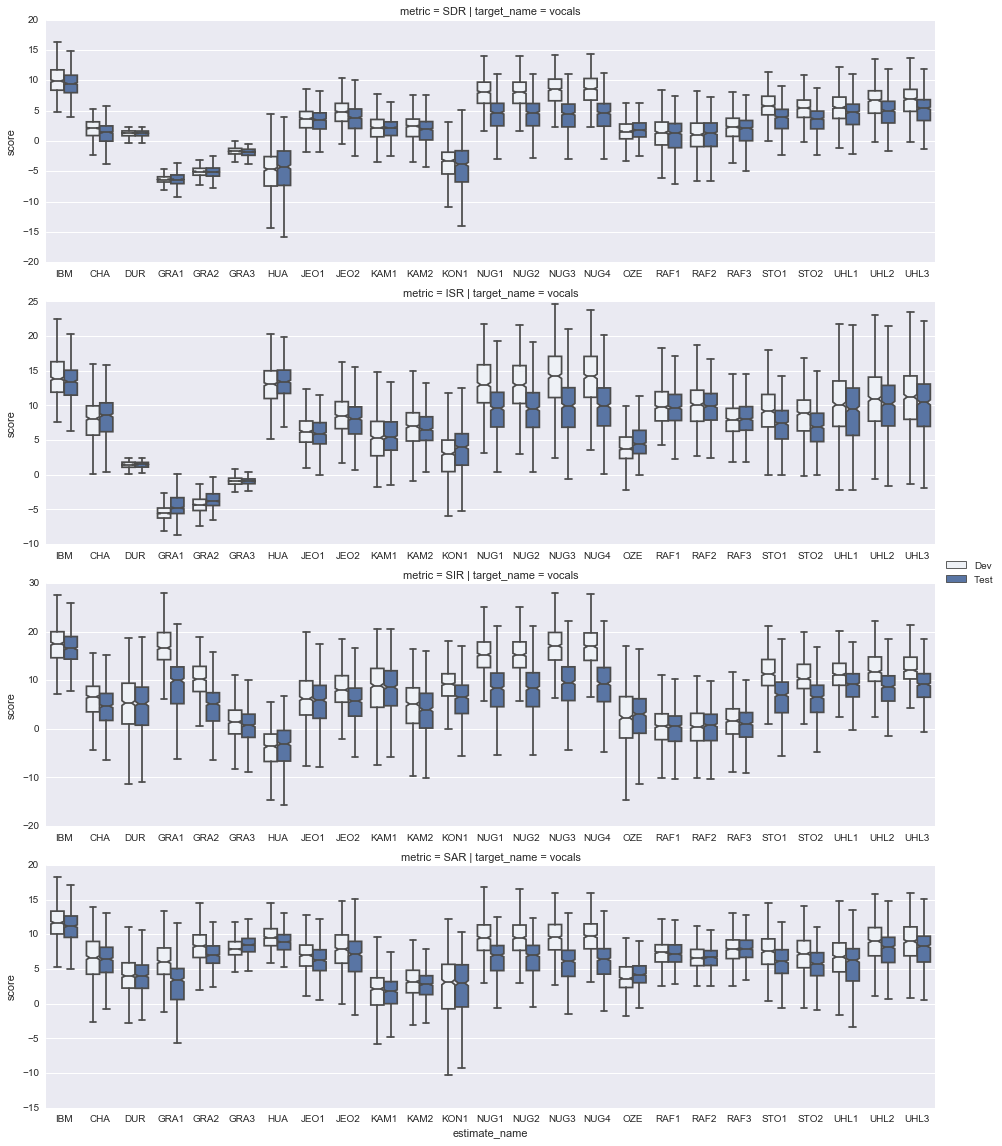

In [45]:
df_vocals = df[df.target_name == "vocals"]

g = sns.FacetGrid(
        df_vocals,
        col="target_name",
        row="metric",
        sharex=False,
        sharey=False,
        legend_out=True,
        palette=sns.color_palette("viridis", 14),
        aspect=3.3,
        size=4
    )
g = (g.map(
    sns.boxplot,
    'estimate_name',
    "score",
    "subset",
    hue_order=['Dev', 'Test'],
    order=estimate_names,
    showmeans=False,
    notch=True,
    showfliers=False,
    width=0.75
).add_legend())
plt.show()

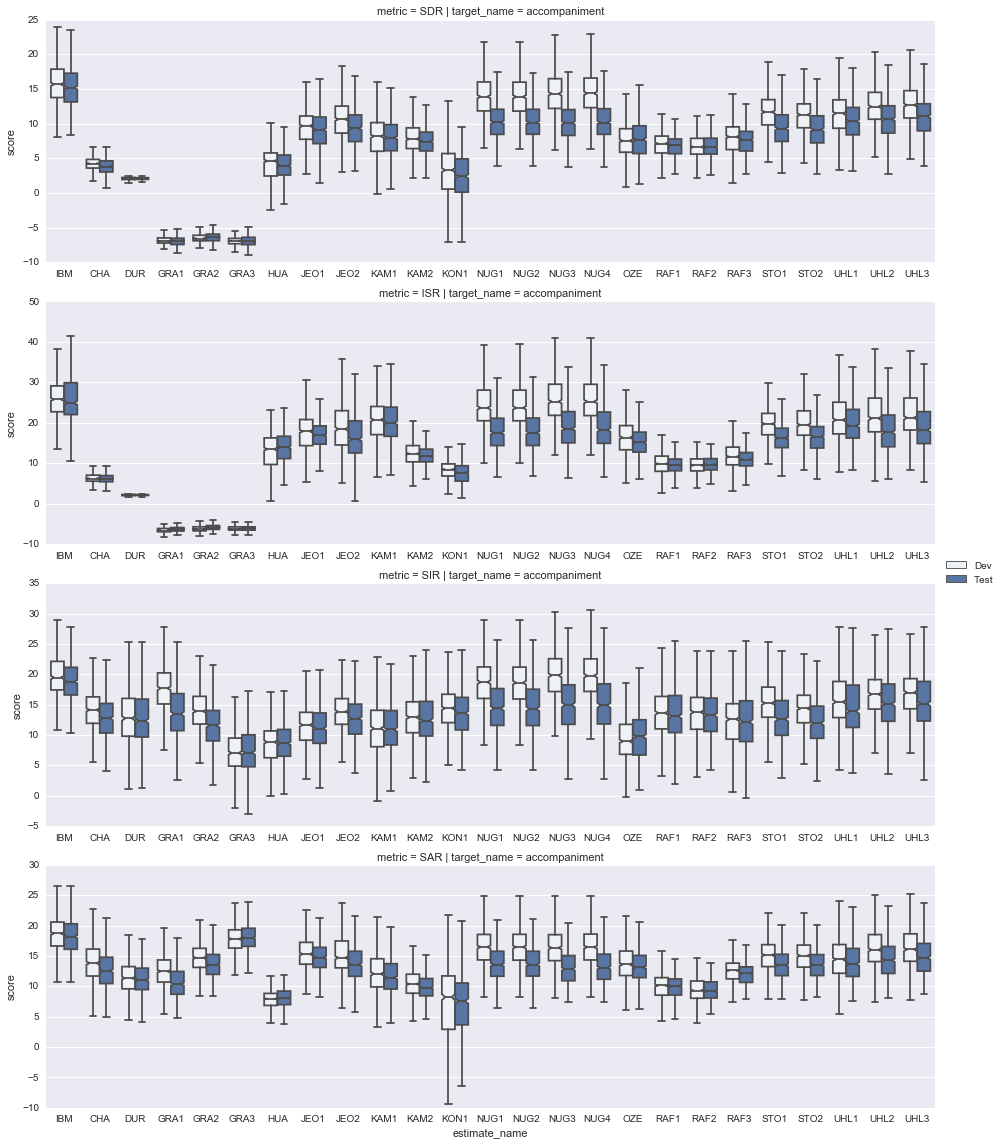

In [46]:
df_acc = df[df.target_name == "accompaniment"]

g = sns.FacetGrid(
        df_acc,
        col="target_name",
        row="metric",
        sharex=False,
        sharey=False,
        legend_out=True,
        palette=sns.color_palette("viridis", 14),
        aspect=3.3,
        size=4
    )
g = (g.map(
    sns.boxplot,
    'estimate_name',
    "score",
    "subset",
    hue_order=['Dev', 'Test'],
    order=estimate_names,
    showmeans=False,
    notch=True,
    showfliers=False,
    width=0.75
).add_legend())
plt.show()

# Tracks (SDR, vocals, Test)

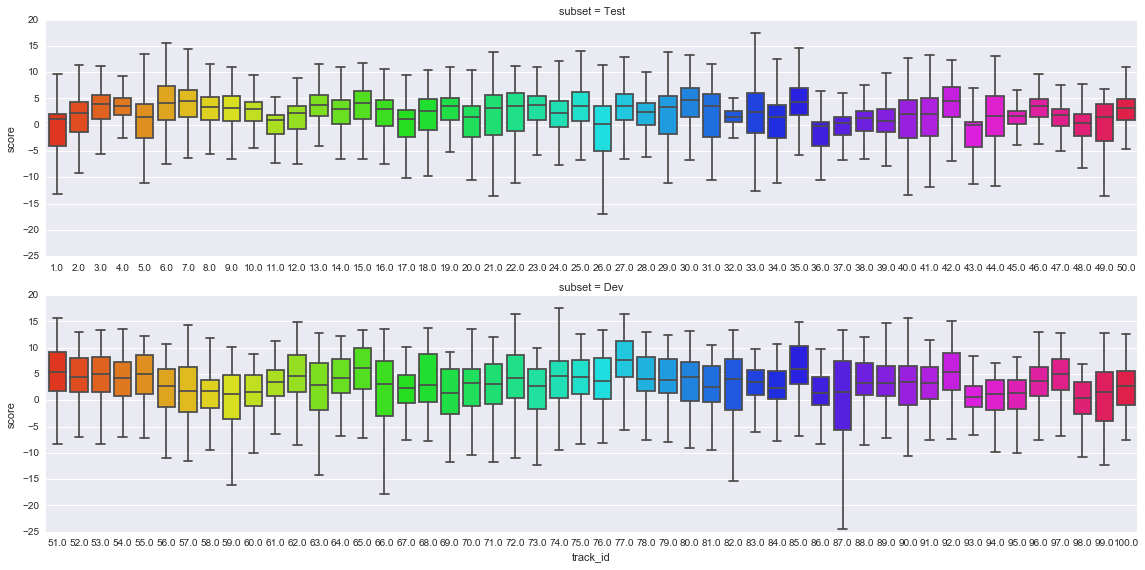

In [47]:
# lets get to see how difficult the songs are in general
df_tracks = df.query(
    'metric == "SDR" and target_name == "vocals"'
)

g = sns.FacetGrid(df_tracks, row="subset", size=4, aspect=4, sharex=False)
g.map(
    sns.boxplot,
    'track_id',
    "score",
    data=df_tracks,
    showmeans=False,
    showfliers=False,
    palette=sns.color_palette("hsv", 50)
)
plt.show()

# Show differences in Framewise evaluation of one track

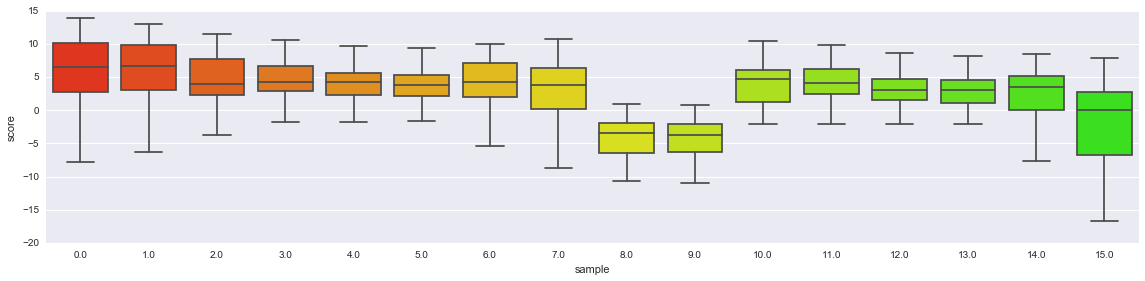

In [48]:
# lets pick one track an show all evaluation frame results per track
df_21 = df.query(
    'metric == "SDR" and target_name == "vocals" and track_id == 21 and subset == "Test"'
)

g = sns.FacetGrid(df_21, size=4, aspect=4, sharex=False)
g.map(
    sns.boxplot,
    'sample',
    "score",
    data=df_21,
    showmeans=False,
    showfliers=False,
    palette=sns.color_palette("hsv", 50)
)
plt.show()


# Dev vs Test for learning methods

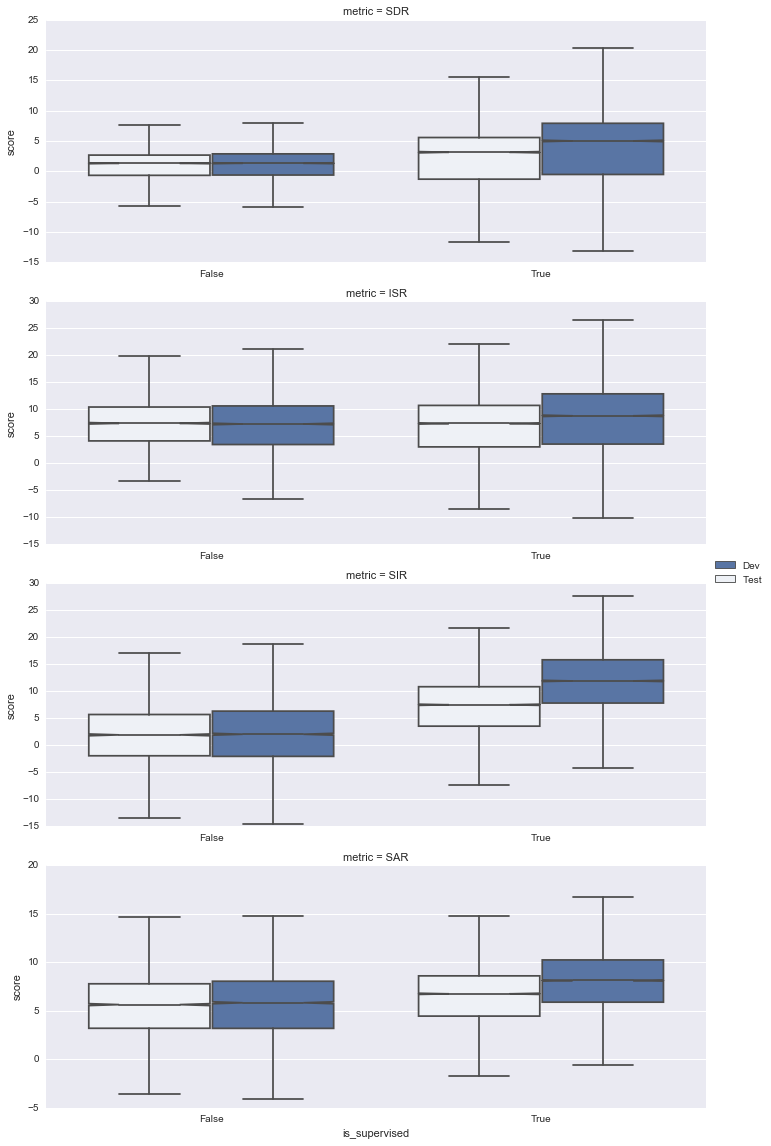

In [52]:
df_vocals = df[df.target_name == "vocals"]

g = sns.FacetGrid(
        df_vocals,
        row="metric",
        sharex=False,
        sharey=False,
        legend_out=True,
        palette=sns.color_palette("viridis", 14),
        aspect=2.5,
        size=4
    )
g = (g.map(
    sns.boxplot,
    'is_supervised',
    "score",
    "subset",
    showmeans=False,
    notch=True,
    showfliers=False,
    width=0.75
).add_legend())
plt.show()

# Using Augmentation vs no augmentation

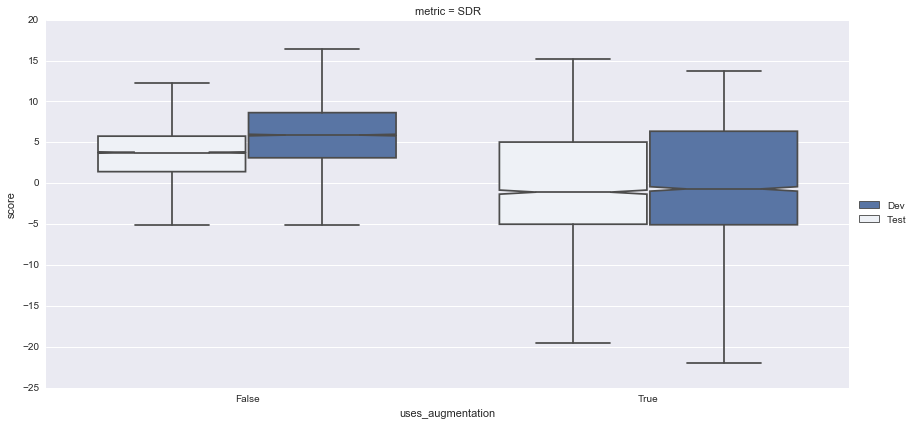

In [53]:
df_supervised = df.query('metric == "SDR" and target_name == "vocals" and is_supervised == True')

g = sns.FacetGrid(
        df_supervised,
        row="metric",
        sharex=False,
        sharey=False,
        legend_out=True,
        palette=sns.color_palette("viridis", 14),
        aspect=2,
        size=6
    )
g = (g.map(
    sns.boxplot,
    'uses_augmentation',
    "score",
    "subset",
    showmeans=False,
    notch=True,
    showfliers=False,
    width=0.75
).add_legend())
plt.show()

# Stastical model of comparisons of methods

In [54]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [55]:
df_sdr_vocals_test = df.query('metric == "SDR" and target_name == "vocals" and subset == "Test"').dropna()
df_sdr_vocals_dev = df.query('metric == "SDR" and target_name == "vocals" and subset == "Dev"').dropna()

### Show the influenence of the method

In [56]:
lm = ols('score ~ C(estimate_name)', df_sdr_vocals_test).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     270.7
Date:                Wed, 17 Aug 2016   Prob (F-statistic):               0.00
Time:                        23:40:19   Log-Likelihood:                -52415.
No. Observations:               16423   AIC:                         1.049e+05
Df Residuals:                   16398   BIC:                         1.051e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

### Vocals/Test: Pairwise comparison tests (basically t-test)

In [57]:
pc_table = sm.stats.multicomp.pairwise_tukeyhsd(df_sdr_vocals_test['score'], df_sdr_vocals_test['estimate_name'])
pc_table.summary()

group1,group2,meandiff,lower,upper,reject
CHA,DUR,0.5241,-0.665,1.7132,False
CHA,GRA1,-7.1959,-8.385,-6.0068,True
CHA,GRA2,-6.0475,-7.2366,-4.8584,True
CHA,GRA3,-2.7224,-3.9115,-1.5333,True
CHA,HUA,-5.553,-6.7421,-4.3639,True
CHA,IBM,9.1187,7.9296,10.3078,True
CHA,JEO1,2.2247,1.0356,3.4138,True
CHA,JEO2,2.6626,1.4735,3.8516,True
CHA,KAM1,1.1139,-0.0752,2.303,False
CHA,KAM2,0.6599,-0.5292,1.849,False


In [58]:
pc_table = sm.stats.multicomp.pairwise_tukeyhsd(df_sdr_vocals_dev['score'], df_sdr_vocals_dev['estimate_name'])
pc_table.summary()

group1,group2,meandiff,lower,upper,reject
CHA,DUR,-0.5048,-1.801,0.7915,False
CHA,GRA1,-7.6841,-8.9803,-6.3879,True
CHA,GRA2,-6.5108,-7.8071,-5.2146,True
CHA,GRA3,-3.5257,-4.8219,-2.2295,True
CHA,HUA,-7.1301,-8.4263,-5.8339,True
CHA,IBM,8.9889,7.6927,10.2851,True
CHA,JEO1,1.568,0.2718,2.8643,True
CHA,JEO2,3.8796,2.5833,5.1758,True
CHA,KAM1,0.3137,-0.9825,1.61,False
CHA,KAM2,0.08,-1.2162,1.3763,False


#### Interpretation

* No method is as good as IBM, yet. Means IBM is always stastically significantly different
* Between NUG1-4: do not produce stat. sig. different results
* Between UHL1-3: only UHL3 is better than 1 and 2
...

### Pairwise comparison plot against IBM

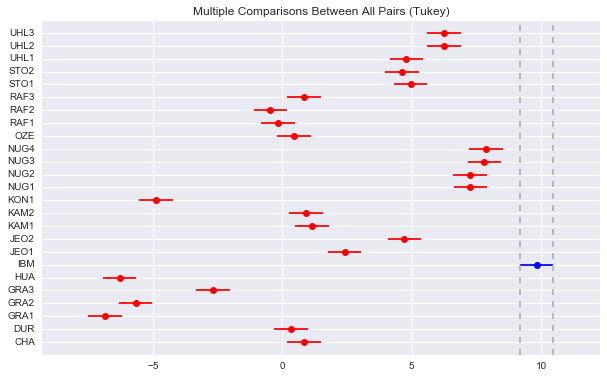

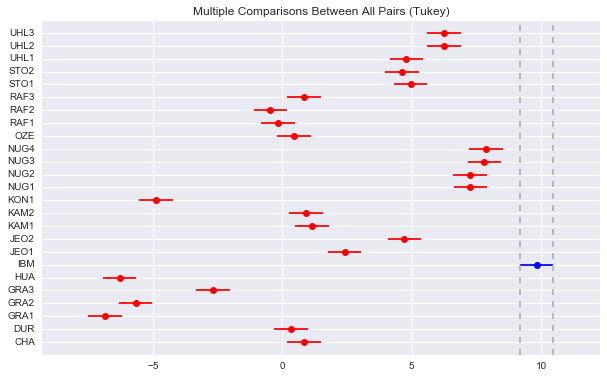

In [59]:
pc_table.plot_simultaneous(comparison_name='IBM')

In [60]:
pc_table = sm.stats.multicomp.pairwise_tukeyhsd(df_sdr_vocals_test['score'], df_sdr_vocals_test['estimate_name'])

df_sdr_vocals_test = pd.DataFrame(columns=['X', 'Y', 'Diff', 'reject'])
pc_table._simultaneous_ci()
for method in pc_table.groupsunique:
    comparison_name = method
    sigidx = []
    nsigidx = []
    means = pc_table._multicomp.groupstats.groupmean

    minrange = [means[i] - pc_table.halfwidths[i] for i in range(len(means))]
    maxrange = [means[i] + pc_table.halfwidths[i] for i in range(len(means))]

    midx = np.where(pc_table.groupsunique==comparison_name)[0]
    for i in range(len(means)):
        if pc_table.groupsunique[i] == comparison_name:
            continue
        if (min(maxrange[i], maxrange[midx]) -
                                 max(minrange[i], minrange[midx]) < 0):
            sigidx.append(i)
        else:
            nsigidx.append(i)

    for i in sigidx:
        series = pd.Series({
            'X': str(method),
            'Y': str(pc_table.groupsunique[i]),
            'Diff': float(means[midx] - means[i]),
            'reject' : True
        })
        df_sdr_vocals_test = df_sdr_vocals_test.append(series, ignore_index=True)
    for i in nsigidx:
        series = pd.Series({
            'X': str(method),
            'Y': str(pc_table.groupsunique[i]),
            'Diff': float(means[midx][0] - means[i]),
            'reject' : False
        })
        df_sdr_vocals_test = df_sdr_vocals_test.append(series, ignore_index=True)

/Users/stf/repositories/SISEC-MUS/.env/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/stf/repositories/SISEC-MUS/.env/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


### Pairwise Heatmap of TEST (currently unordered)

In [61]:
df_pivot = df_sdr_vocals_test.pivot("X", "Y", "Diff")
df_reject = df_sdr_vocals_test.pivot("X", "Y", "reject").as_matrix()
reject_matrix = np.array(df_reject, dtype=np.float)
reject_matrix[np.isnan(reject_matrix)] = -1

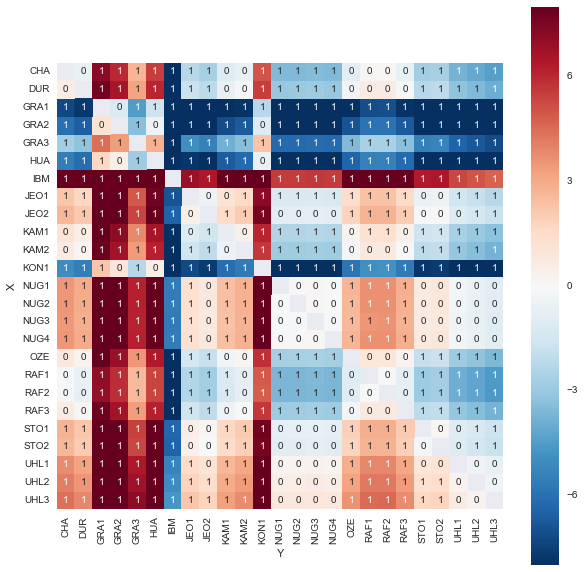

In [62]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(df_pivot, square=True, ax=ax, cmap='RdBu_r', vmax=8, vmin=-8, annot=reject_matrix)
plt.savefig('heatmap.eps')